In [2]:
import dataclasses

import jax
import jax.numpy as jnp
import pylab as plt
import tensorflow_probability.substrates.jax as tfp

from essm_jax.essm import ExtendedStateSpaceModel

tfpd = tfp.distributions


Let's define the dampled harmonic oscillator

$$m \ddot x= - c \dot x - k (x-x_0) + f(t)$$
$$\iff \ddot x = - 2 \zeta \omega \dot x - \omega^2 (x - x_0) + \frac{f(t)}{m}$$

with $\omega = \frac{k}{m} \in \mathbb{R}^+$, $\zeta = \frac{c}{2 \sqrt{mk}} \in \mathbb{R}^+$ and $f(t) \sim \mathcal{N}[0, \sigma_f^2]$.

Let us make this non-linear by supposing that $M = \log m \sim \mathcal{N}[\bar{M}, \sigma_M^2]$.

This defines a state,

$$ z = [x, v, M]$$

transition mean function,

$$ z_{t}, t \to [x + v \Delta t, v + \frac{(f(t) -c v - k x)}{m} \Delta t, \bar M]$$

transition noise scale function,

$$ z_{t}, t \to [0, \sigma_f, \sigma_M]$$

observation mean function,

$$ z_{t}, t \to [x, 0, 0]$$

and observation noise scale function,

$$ z_{t}, t \to [\sigma_x, 0, 0]$$


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


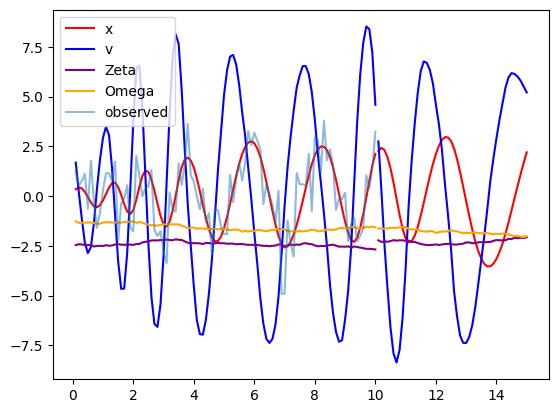

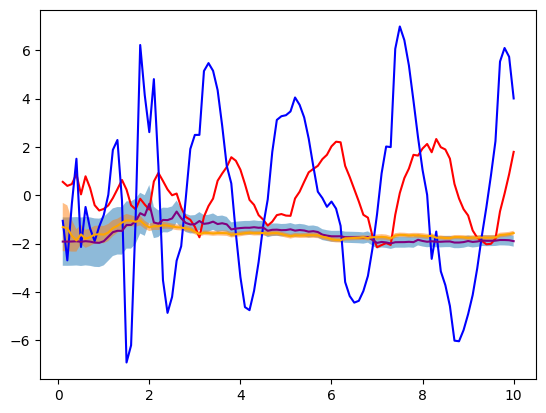

In [3]:

from tensorflow_probability.substrates.jax.internal import special_math
from jax import lax
from jax._src.scipy.special import ndtri
from essm_jax.pytee_utils import pytree_unravel
from typing import NamedTuple


class State(NamedTuple):
    """
    State for a single timestep of the Kalman filter.
    """
    x: jax.Array  # [n]
    v: jax.Array  # [n]
    Zeta: jax.Array  # [n]
    Omega: jax.Array  # [n]


class Observation(NamedTuple):
    """
    Observables for a single timestep of the Kalman filter.
    """
    x: jax.Array  # [n]


n = 1  # Single dimension


@dataclasses.dataclass(eq=False)
class ExcitedDampedHarmonicOscillator:
    n: int = 1
    dt: float = 0.01
    x0: float = 0.
    sigma_f: float = 0.1
    sigma_x: float = 0.1
    sigma_Zeta: float = 0.01
    sigma_Omega: float = 0.01
    zeta0: float = 0.1
    omega0: float = 1.

    def __post_init__(self):
        example_state = State(
            x=jnp.ones((n,)),
            v=jnp.ones((n,)),
            Zeta=jnp.ones((n,)),
            Omega=jnp.ones((n,)),
        )

        example_observation = Observation(
            x=jnp.ones((n,))
        )

        self.state_ravel_fn, self.state_unravel_fn = pytree_unravel(example_state)
        self.obs_ravel_fn, self.obs_unravel_fn = pytree_unravel(example_observation)

    def batched_state_ravel_fn(self, state: State) -> jax.Array:
        """
        Ravel a state with batched time axis into batched flat states.
        """
        # This is needed because calling ravel is only defined on the per element basis.
        return jax.vmap(self.state_ravel_fn)(state)

    def batched_state_unravel_fn(self, flat_state: jax.Array) -> State:
        """
        Unravel a batched flat state into a state with batched time axis.
        """
        # This is needed because calling unravel is only defined on the per element basis.
        return jax.vmap(self.state_unravel_fn)(flat_state)

    def batched_observables_ravel_fn(self, observation: Observation) -> jax.Array:
        """
        Ravel observables with batched time axis into batched flat observables.
        """
        # This is needed because calling ravel is only defined on the per element basis.
        return jax.vmap(self.obs_ravel_fn)(observation)

    def batched_observables_unravel_fn(self, flat_observables: jax.Array) -> Observation:
        """
        Unravel a batched flat observables into observables with batched time axis.
        """
        # This is needed because calling unravel is only defined on the per element basis.
        return jax.vmap(self.obs_unravel_fn)(flat_observables)

    def transition_fn(self, z: jax.Array, t: jax.Array, t_next: jax.Array, *args) -> tfpd.MultivariateNormalLinearOperator:
        dt = t_next - t
        state = self.state_unravel_fn(z)
        zeta = self.constrain_zeta_fn(state.Zeta)
        omega = self.constrain_omega_fn(state.Omega)
        c = 2. * zeta * omega
        k = omega ** 2
        a_mean = (-c * state.v - k * (state.x - self.x0))
        adt = a_mean * dt
        next_state_mean = State(
            x=state.x + state.v * dt + 0.5 * adt * dt,
            v=state.v + adt,
            Zeta=state.Zeta,
            Omega=state.Omega
        )
        var_f = self.sigma_f ** 2
        zero = jnp.zeros((self.n,))
        ones = jnp.ones((self.n,))
        # Cov divided by var_f * dt**2 +  1e-6 I
        cov_x = State(x=0.25 * dt ** 2 * ones + 1e-6, v=0.5 * dt * ones, Zeta=zero, Omega=zero)
        cov_v = State(x=0.5 * dt * ones, v=ones + 1e-6, Zeta=zero, Omega=zero)
        cov_Zeta = State(x=zero, v=zero, Zeta=self.sigma_Zeta ** 2 / (var_f * dt) * ones + 1e-6, Omega=zero)
        cov_Omega = State(x=zero, v=zero, Zeta=zero, Omega=self.sigma_Omega ** 2 / (var_f * dt) * ones + 1e-6)
        next_state_cov = State(
            x=self.state_ravel_fn(cov_x),
            v=self.state_ravel_fn(cov_v),
            Zeta=self.state_ravel_fn(cov_Zeta),
            Omega=self.state_ravel_fn(cov_Omega)
        )
        sqrt_small_factor = self.sigma_f * dt
        return tfpd.MultivariateNormalTriL(
            self.state_ravel_fn(next_state_mean),
            sqrt_small_factor * lax.linalg.cholesky(self.batched_state_ravel_fn(next_state_cov),
                                                    symmetrize_input=False)
        )

    def observation_fn(self, z: jax.Array, t: jax.Array, *args) -> tfpd.MultivariateNormalLinearOperator:
        state = self.state_unravel_fn(z)
        obs_mean = Observation(
            x=state.x,
        )
        obs_scale = Observation(
            x=self.sigma_x * jnp.ones_like(state.x),
        )
        return tfpd.MultivariateNormalDiag(self.obs_ravel_fn(obs_mean), self.obs_ravel_fn(obs_scale))

    def constrain_zeta_fn(self, Zeta: jax.Array) -> jax.Array:
        concentration1 = 2 * jnp.ones((self.n,))
        concentration0 = 2 * jnp.ones((self.n,))
        zeta_dist = tfpd.Beta(concentration1=concentration1, concentration0=concentration0)
        u = special_math.ndtr(Zeta)
        zeta = zeta_dist.quantile(u)
        return zeta

    def constrain_omega_fn(self, Omega: jax.Array) -> jax.Array:
        low = jnp.zeros((self.n,))
        high = 2 * jnp.pi * jnp.ones((self.n,)) * 10.
        omega_dist = tfpd.Uniform(low=low, high=high)
        u = special_math.ndtr(Omega)
        omega = omega_dist.quantile(u)
        return omega

    def unconstrain_zeta_fn(self, zeta: jax.Array) -> jax.Array:
        concentration1 = 2 * jnp.ones((self.n,))
        concentration0 = 2 * jnp.ones((self.n,))
        zeta_dist = tfpd.Beta(concentration1=concentration1, concentration0=concentration0)
        u = zeta_dist.cdf(zeta)
        Zeta = ndtri(u)
        return Zeta

    def unconstrain_omega_fn(self, omega: jax.Array) -> jax.Array:
        low = jnp.zeros((self.n,))
        high = 2 * jnp.pi * jnp.ones((self.n,)) * 10.
        omega_dist = tfpd.Uniform(low=low, high=high)
        u = omega_dist.cdf(omega)
        Omega = ndtri(u)
        return Omega

    def create_initial_state_prior(self) -> tfpd.MultivariateNormalLinearOperator:
        initial_state = State(
            x=0.*jnp.ones((self.n,)),
            v=jnp.ones((self.n,)),
            Zeta=self.unconstrain_zeta_fn(self.zeta0 * jnp.ones((self.n,))),
            Omega=self.unconstrain_omega_fn(self.omega0 * jnp.ones((self.n,))),
        )
        initial_state_scale = State(
            x=jnp.ones((self.n,)),
            v=jnp.ones((self.n,)),
            Zeta=jnp.ones((self.n,)),
            Omega=jnp.ones((self.n,)),
        )
        return tfpd.MultivariateNormalDiag(self.state_ravel_fn(initial_state), self.state_ravel_fn(initial_state_scale))

    def build_essm(self):
        return ExtendedStateSpaceModel(
            transition_fn=self.transition_fn,
            observation_fn=self.observation_fn,
            initial_state_prior=self.create_initial_state_prior(),
            more_data_than_params=False,
            dt=self.dt
        )


model = ExcitedDampedHarmonicOscillator(
    n=1,
    dt=0.1,
    x0=0.,
    sigma_f=0.5,
    sigma_x=1.,
    sigma_Zeta=0.1,
    sigma_Omega=0.1,
    zeta0=0.1,
    omega0=6.
)

T = int(10 / model.dt)

essm = model.build_essm()

samples = essm.sample(key=jax.random.PRNGKey(0), num_time=T)

filter_result = essm.forward_filter(observations=samples.observation)
smooth_result = essm.backward_smooth(filter_result=filter_result)

future_samples = essm.forward_simulate(key=jax.random.PRNGKey(0), num_time=int(5 / model.dt),
                                       filter_result=filter_result)
future_latent = model.batched_state_unravel_fn(future_samples.latent)

obs = model.batched_observables_unravel_fn(samples.observation)
state = model.batched_state_unravel_fn(samples.latent)
plt.plot(samples.t, state.x, label='x', c='r')
plt.plot(samples.t, state.v, label='v', c='b')
plt.plot(samples.t, state.Zeta, label='Zeta', c='purple')
plt.plot(samples.t, state.Omega, label='Omega', c='orange')
plt.plot(samples.t, obs.x, label='observed', alpha=0.5)

plt.plot(future_samples.t, future_latent.x, c='r')
plt.plot(future_samples.t, future_latent.v, c='b')
plt.plot(future_samples.t, future_latent.Zeta, c='purple')
plt.plot(future_samples.t, future_latent.Omega, c='orange')

plt.legend()
plt.show()

filter_latent = model.batched_state_unravel_fn(filter_result.filtered_mean)
filter_latent_std = model.batched_state_unravel_fn(jnp.sqrt(jax.vmap(jnp.diag)(filter_result.filtered_cov)))

plt.plot(filter_result.t, filter_latent.x, label='x', c='r')
plt.plot(filter_result.t, filter_latent.v, label='v', c='b')
plt.plot(filter_result.t, filter_latent.Zeta, label='Zeta', c='purple')
plt.fill_between(
    filter_result.t, filter_latent.Zeta[:, 0] - filter_latent_std.Zeta[:, 0],
                     filter_latent.Zeta[:, 0] + filter_latent_std.Zeta[:, 0],
    alpha=0.5
)
plt.plot(filter_result.t, filter_latent.Omega, label='Omega', c='orange')
plt.fill_between(
    filter_result.t, filter_latent.Omega[:, 0] - filter_latent_std.Omega[:, 0],
                     filter_latent.Omega[:, 0] + filter_latent_std.Omega[:, 0],
    alpha=0.5
)

/tmp/ipykernel_1254184/980648694.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


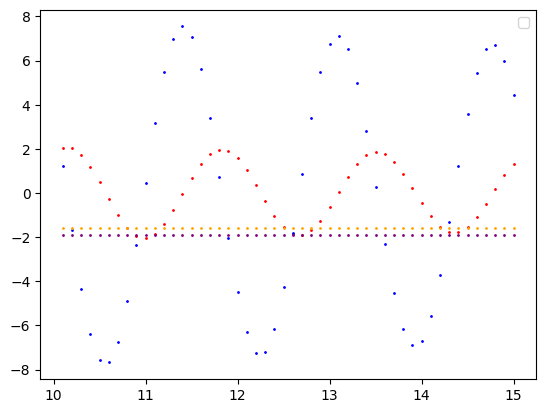

In [4]:

filter_state = essm.create_filter_state(filter_result=filter_result)
for _ in range(int(5 / model.dt)):
    filter_state = essm.incremental_predict(filter_state=filter_state)
    latent = model.state_unravel_fn(filter_state.filtered_mean)
    plt.scatter(filter_state.t, latent.x, c='r', s=1)
    plt.scatter(filter_state.t, latent.v, c='b', s=1)
    plt.scatter(filter_state.t, latent.Zeta, c='purple', s=1)
    plt.scatter(filter_state.t, latent.Omega, c='orange', s=1)

plt.legend()
plt.show()

